In [2]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

In [ ]:
def convert_file_to_csv():
    try:
        # Try different encodings that might work
        encodings = ['latin1', 'cp1252', 'iso-8859-1']
        
        for encoding in encodings:
            try:
                # Read the tab-delimited file with specific encoding
                df = pd.read_csv('UCMR4_ALL.txt', 
                               sep='\t',
                               encoding=encoding,
                               on_bad_lines='skip')  # Skip problematic lines
                
                # Export to CSV with the same encoding
                df.to_csv('water_quality_data.csv', 
                         index=False,
                         encoding=encoding)
                
                print(f"Successfully used {encoding} encoding")
                
                # Print first few rows to verify
                print("\nFirst few rows of the converted data:")
                print(df.head())
                
                print("\nConversion completed successfully. File saved as 'water_quality_data.csv'")
                
                # If successful, break the loop
                break
                
            except UnicodeDecodeError:
                print(f"Failed with {encoding} encoding, trying next...")
                continue
            
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Run the conversion
convert_file_to_csv()

Successfully used latin1 encoding

First few rows of the converted data:
       PWSID                    PWSName Size  FacilityID  \
0  010106001  Mashantucket Pequot Water    L           1   
1  010106001  Mashantucket Pequot Water    L           1   
2  010106001  Mashantucket Pequot Water    L           1   
3  010106001  Mashantucket Pequot Water    L           1   
4  010106001  Mashantucket Pequot Water    L           1   

               FacilityName FacilityWaterType SamplePointID  SamplePointName  \
0  MPTN Distribution System                GU           D12  4 Pequot Circle   
1  MPTN Distribution System                GU           D12  4 Pequot Circle   
2  MPTN Distribution System                GU           D12  4 Pequot Circle   
3  MPTN Distribution System                GU           D12  4 Pequot Circle   
4  MPTN Distribution System                GU           D12  4 Pequot Circle   

  SamplePointType  AssociatedFacilityID  ...  MRL Units   MethodID  \
0              

In [3]:
df = pd.read_csv('water_quality_data.csv', encoding='latin1')

In [4]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head(1)

Dataset Shape: (932854, 24)

Columns: ['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName', 'FacilityWaterType', 'SamplePointID', 'SamplePointName', 'SamplePointType', 'AssociatedFacilityID', 'AssociatedSamplePointID', 'CollectionDate', 'SampleID', 'Contaminant', 'MRL', 'Units', 'MethodID', 'AnalyticalResultsSign', 'AnalyticalResultValue', 'SampleEventCode', 'MonitoringRequirement', 'Region', 'State', 'UCMR1SampleType']

First few rows:


,PWSID,PWSName,Size,FacilityID,FacilityName,FacilityWaterType,SamplePointID,SamplePointName,SamplePointType,AssociatedFacilityID,...,MRL,Units,MethodID,AnalyticalResultsSign,AnalyticalResultValue,SampleEventCode,MonitoringRequirement,Region,State,UCMR1SampleType
0,010106001,Mashantucket Pequot Water,L,1,MPTN Distribution System,GU,D12,4 Pequot Circle,DS,NaN,...,NaN,µg/L,EPA 552.3,=,17.342,SE1,AM,1,01,NaN


In [5]:
# Cell 3: Initial Data Processing
# Convert date
df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])

# Handle results below MRL
df['Value'] = np.where(df['AnalyticalResultsSign'] == '<', 
                      df['MRL'] / 2,  # Use half the MRL for non-detects
                      df['AnalyticalResultValue'])

# Create geographic grouping
df['RegionState'] = df['Region'].astype(str) + '_' + df['State']

# Display summary statistics
print("Data Summary:")
print(f"Number of unique water systems: {df['PWSID'].nunique()}")
print(f"Date range: {df['CollectionDate'].min()} to {df['CollectionDate'].max()}")
print(f"Number of Regions: {df['Region'].nunique()}")
print(f"Water Types: {df['FacilityWaterType'].unique()}")

# Display summary of PFAS measurements
print("\nPFAS Measurements Summary:")
print(df['Value'].describe())

Data Summary:
Number of unique water systems: 5833
Date range: 2018-01-02 00:00:00 to 2021-12-17 00:00:00
Number of Regions: 10
Water Types: ['GU' 'SW' 'GW' 'MX']

PFAS Measurements Summary:
count    932854.000000
mean          4.046349
std          16.652920
min           0.000000
25%           0.015000
50%           0.100000
75%           0.879000
max        3960.000000
Name: Value, dtype: float64


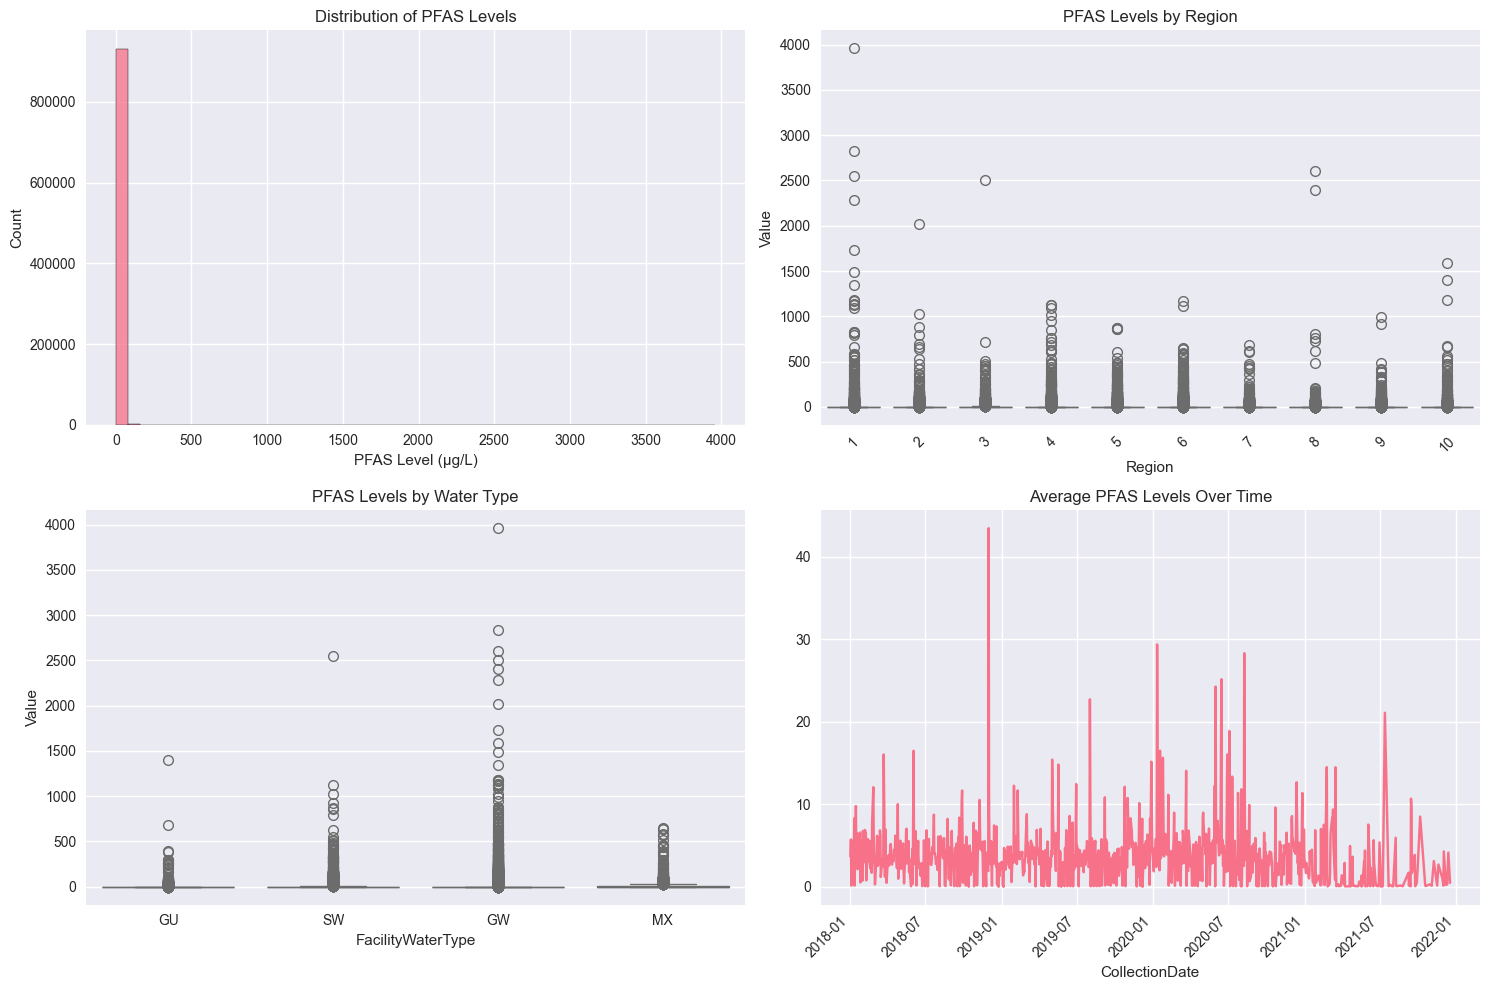

In [6]:
# Cell 4: Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Plot 1: PFAS Levels Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Value'], bins=50)
plt.title('Distribution of PFAS Levels')
plt.xlabel('PFAS Level (μg/L)')

# Plot 2: PFAS Levels by Region
plt.subplot(2, 2, 2)
sns.boxplot(x='Region', y='Value', data=df)
plt.title('PFAS Levels by Region')
plt.xticks(rotation=45)

# Plot 3: PFAS Levels by Water Type
plt.subplot(2, 2, 3)
sns.boxplot(x='FacilityWaterType', y='Value', data=df)
plt.title('PFAS Levels by Water Type')

# Plot 4: PFAS Levels Over Time
plt.subplot(2, 2, 4)
df.groupby('CollectionDate')['Value'].mean().plot()
plt.title('Average PFAS Levels Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Cell 5: Feature Engineering
# Create time-based features
df['Month'] = df['CollectionDate'].dt.month
df['Year'] = df['CollectionDate'].dt.year

# Create water system size indicator
df['IsLarge'] = (df['Size'] == 'L').astype(int)

# Create water type indicators
water_type_dummies = pd.get_dummies(df['FacilityWaterType'], prefix='WaterType')
df = pd.concat([df, water_type_dummies], axis=1)

# Create regional indicators
region_dummies = pd.get_dummies(df['Region'], prefix='Region')
df = pd.concat([df, region_dummies], axis=1)

# Display the new features
print("Features created. New columns:")
print(df.columns[-15:].tolist())  # Show last 15 columns

Features created. New columns:
['IsLarge', 'WaterType_GU', 'WaterType_GW', 'WaterType_MX', 'WaterType_SW', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'Region_10']


In [8]:
# Cell 6: Data Aggregation
# Group data by date and region for analysis
def aggregate_data(df):
    grouped = df.groupby(['CollectionDate', 'Region']).agg({
        'Value': ['mean', 'median', 'std', 'count'],
        'IsLarge': 'mean',
        'WaterType_GW': 'mean',
        'WaterType_SW': 'mean',
        'WaterType_GU': 'mean',
        'WaterType_MX': 'mean'
    }).reset_index()
    
    grouped.columns = ['CollectionDate', 'Region', 'Value_mean', 'Value_median', 
                      'Value_std', 'Sample_count', 'Large_system_ratio',
                      'GW_ratio', 'SW_ratio', 'GU_ratio', 'MX_ratio']
    return grouped

# Aggregate the data
df_agg = aggregate_data(df)
print("Aggregated data shape:", df_agg.shape)
print("\nFirst few rows of aggregated data:")
df_agg.head()

Aggregated data shape: (6616, 11)

First few rows of aggregated data:


,CollectionDate,Region,Value_mean,Value_median,Value_std,Sample_count,Large_system_ratio,GW_ratio,SW_ratio,GU_ratio,MX_ratio
0,2018-01-02,2,0.418426,0.035,1.209132,17,1.0,1.000000,0.000000,0.0,0.0
1,2018-01-02,4,5.852680,1.000,8.421482,50,1.0,1.000000,0.000000,0.0,0.0
2,2018-01-02,6,0.129567,0.025,0.253017,15,1.0,0.000000,1.000000,0.0,0.0
3,2018-01-03,2,2.297969,0.100,5.762931,63,1.0,0.809524,0.190476,0.0,0.0
4,2018-01-03,6,10.778919,5.418,12.219772,43,1.0,0.000000,1.000000,0.0,0.0


In [16]:
import pandas as pd
import numpy as np
from datetime import datetime

def process_water_data(df):
    # Convert CollectionDate to datetime
    df['CollectionDate'] = pd.to_datetime(df['CollectionDate'])
    
    # Create binary column for system size
    df['IsLarge'] = (df['Size'] == 'L').astype(int)
    
    # Create dummy variables for water types
    water_types = pd.get_dummies(df['FacilityWaterType'], prefix='WaterType')
    df = pd.concat([df, water_types], axis=1)
    
    # Convert AnalyticalResultValue to numeric, handling any non-numeric values
    df['Value'] = pd.to_numeric(df['AnalyticalResultValue'], errors='coerce')
    
    return df

def aggregate_data(df):
    # Extract date components
    df['Month'] = df['CollectionDate'].dt.month
    df['Year'] = df['CollectionDate'].dt.year
    
    # Group data by date, region, and contaminant
    grouped = df.groupby(['CollectionDate', 'Region', 'Contaminant']).agg({
        'Value': ['mean', 'median', 'std', 'count'],
        'IsLarge': 'mean',
        'WaterType_GW': 'mean',
        'WaterType_SW': 'mean',
        'WaterType_GU': 'mean',
        'WaterType_MX': 'mean',
        'Month': 'first',
        'Year': 'first'
    }).reset_index()
    
    # Flatten column names
    grouped.columns = ['CollectionDate', 'Region', 'Contaminant',
                      'Value_mean', 'Value_median', 'Value_std', 'Sample_count',
                      'Large_system_ratio', 'GW_ratio', 'SW_ratio', 'GU_ratio',
                      'MX_ratio', 'Month', 'Year']
    
    return grouped

# Read the data
df = pd.read_csv('water_quality_data.csv', encoding='latin1')

# Process the data
df_processed = process_water_data(df)

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head(1).to_string())

# Display data summary
print("\nData Summary:")
print(f"Number of unique water systems: {df['PWSID'].nunique()}")
print(f"Date range: {df['CollectionDate'].min()} to {df['CollectionDate'].max()}")
print(f"Number of Regions: {df['Region'].nunique()}")
print(f"Water Types: {df['FacilityWaterType'].unique()}")

# Display measurement summary statistics
print("\nPFAS Measurements Summary:")
print(df_processed['Value'].describe())

# Create features
features_created = ['IsLarge'] + [col for col in df_processed.columns if col.startswith('WaterType_')]
print("\nFeatures created. New columns:")
print(features_created)

# Aggregate the data
df_agg = aggregate_data(df_processed)
print("Aggregated data shape:", df_agg.shape)
print("\nFirst few rows of aggregated data:")
print(df_agg.head())

# Create summary of PFAS compounds
pfas_summary = df_processed.groupby('Contaminant').agg({
    'Value': ['count', 'mean', 'median', 'std'],
    'AnalyticalResultsSign': lambda x: (x == '=').mean()  # Detection rate
}).round(4)

pfas_summary.columns = ['Sample_Count', 'Mean', 'Median', 'Std', 'Detection_Rate']
print("\nPFAS Compounds Summary:")
print(pfas_summary.sort_values('Detection_Rate', ascending=False))

Dataset Shape: (932854, 25)

Columns: ['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName', 'FacilityWaterType', 'SamplePointID', 'SamplePointName', 'SamplePointType', 'AssociatedFacilityID', 'AssociatedSamplePointID', 'CollectionDate', 'SampleID', 'Contaminant', 'MRL', 'Units', 'MethodID', 'AnalyticalResultsSign', 'AnalyticalResultValue', 'SampleEventCode', 'MonitoringRequirement', 'Region', 'State', 'UCMR1SampleType', 'IsLarge']

First few rows:
       PWSID                    PWSName Size  FacilityID              FacilityName FacilityWaterType SamplePointID  SamplePointName SamplePointType  AssociatedFacilityID  AssociatedSamplePointID CollectionDate SampleID Contaminant  MRL Units   MethodID AnalyticalResultsSign  AnalyticalResultValue SampleEventCode MonitoringRequirement  Region State  UCMR1SampleType  IsLarge
0  010106001  Mashantucket Pequot Water    L           1  MPTN Distribution System                GU           D12  4 Pequot Circle              DS                   N

In [17]:
def prepare_modeling_data(df_agg, target_contaminant):
    """
    Prepare data for modeling by filtering for specific contaminant
    and creating appropriate feature sets
    """
    # Filter for specific contaminant
    df_cont = df_agg[df_agg['Contaminant'] == target_contaminant].copy()
    
    # Create features for modeling
    features = ['Month', 'Year', 'Large_system_ratio', 
               'GW_ratio', 'SW_ratio', 'GU_ratio', 'MX_ratio', 
               'Sample_count']
    
    # Split data temporally - using July 1st, 2023 as cutoff
    cutoff_date = '2023-07-01'
    train_mask = pd.to_datetime(df_cont['CollectionDate']) < cutoff_date
    
    # Create training and testing sets
    X_train = df_cont[train_mask][features]
    y_train = df_cont[train_mask]['Value_mean']
    X_test = df_cont[~train_mask][features]
    y_test = df_cont[~train_mask]['Value_mean']
    
    return X_train, X_test, y_train, y_test, features

# Looking at the top 5 most detected contaminants from the summary
top_contaminants = pfas_summary.nlargest(5, 'Detection_Rate').index.tolist()
print("\nTop 5 most detected contaminants:")
print(top_contaminants)

# Prepare modeling data for the first contaminant
contaminant = top_contaminants[0]
X_train, X_test, y_train, y_test, features = prepare_modeling_data(df_agg, contaminant)

print(f"\nPrepared modeling data for {contaminant}:")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Features used:", features)


Top 5 most detected contaminants:
['HAA5', 'HAA6Br', 'HAA9', 'manganese', 'microcystin-LA']

Prepared modeling data for HAA5:
Training set shape: (4868, 8)
Testing set shape: (0, 8)
Features used: ['Month', 'Year', 'Large_system_ratio', 'GW_ratio', 'SW_ratio', 'GU_ratio', 'MX_ratio', 'Sample_count']


In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def build_improved_prediction_model(df_agg, contaminant='HAA5'):
    # Filter data for the specific contaminant
    df_cont = df_agg[df_agg['Contaminant'] == contaminant].copy()
    
    # Create additional features
    df_cont['Season'] = pd.to_datetime(df_cont['CollectionDate']).dt.quarter
    df_cont['DaysInYear'] = pd.to_datetime(df_cont['CollectionDate']).dt.dayofyear
    
    # Create interaction features
    df_cont['GW_SW_Ratio'] = df_cont['GW_ratio'] * df_cont['SW_ratio']
    df_cont['Season_GW'] = df_cont['Season'] * df_cont['GW_ratio']
    df_cont['Season_SW'] = df_cont['Season'] * df_cont['SW_ratio']
    
    # Define features
    features = [
        'Month', 'Year', 'Season', 'DaysInYear',
        'Large_system_ratio', 
        'GW_ratio', 'SW_ratio', 'GU_ratio', 'MX_ratio',
        'Sample_count',
        'GW_SW_Ratio', 'Season_GW', 'Season_SW'
    ]
    
    # Remove rows with NaN values
    df_cont = df_cont.dropna(subset=features + ['Value_mean'])
    
    # Scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(df_cont[features]), columns=features)
    y = df_cont['Value_mean']
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize model with optimized parameters
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    )
    
    # Perform cross-validation
    cv_scores = {
        'train_rmse': [],
        'val_rmse': [],
        'train_r2': [],
        'val_r2': []
    }
    
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        cv_scores['train_rmse'].append(np.sqrt(mean_squared_error(y_train, train_pred)))
        cv_scores['val_rmse'].append(np.sqrt(mean_squared_error(y_val, val_pred)))
        cv_scores['train_r2'].append(r2_score(y_train, train_pred))
        cv_scores['val_r2'].append(r2_score(y_val, val_pred))
    
    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Final fit on all data
    model.fit(X, y)
    
    return model, cv_scores, feature_importance, scaler, features

# Build and evaluate the improved model
model, cv_scores, feature_importance, scaler, features = build_improved_prediction_model(df_agg)

# Print cross-validation results
print("\nCross-validation Results:")
for metric, scores in cv_scores.items():
    print(f"{metric}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

print("\nFeature Importance:")
print(feature_importance)


Cross-validation Results:
train_rmse: 10.9585 (+/- 0.8085)
val_rmse: 11.6957 (+/- 2.0694)
train_r2: 0.4025 (+/- 0.0130)
val_r2: 0.1678 (+/- 0.0394)

Feature Importance:
               feature  importance
3           DaysInYear    0.180295
6             SW_ratio    0.170721
12           Season_SW    0.132144
5             GW_ratio    0.127782
9         Sample_count    0.089330
11           Season_GW    0.085745
0                Month    0.051434
8             MX_ratio    0.046021
1                 Year    0.032700
10         GW_SW_Ratio    0.030653
4   Large_system_ratio    0.027419
2               Season    0.019733
7             GU_ratio    0.006023


In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def build_optimized_model(df_agg, contaminant='HAA5'):
    # Filter data for the specific contaminant
    df_cont = df_agg[df_agg['Contaminant'] == contaminant].copy()
    
    # Enhanced feature engineering
    df_cont['DaysInYear'] = pd.to_datetime(df_cont['CollectionDate']).dt.dayofyear
    df_cont['Season'] = pd.to_datetime(df_cont['CollectionDate']).dt.quarter
    df_cont['MonthSin'] = np.sin(2 * np.pi * df_cont['Month']/12)
    df_cont['MonthCos'] = np.cos(2 * np.pi * df_cont['Month']/12)
    
    # Water type interactions
    df_cont['GW_SW_Ratio'] = df_cont['GW_ratio'] * df_cont['SW_ratio']
    df_cont['Season_SW'] = df_cont['Season'] * df_cont['SW_ratio']
    df_cont['Season_GW'] = df_cont['Season'] * df_cont['GW_ratio']
    
    # Rolling statistics for sample counts (last 3 months)
    df_cont['Sample_count_MA3'] = df_cont.groupby('Region')['Sample_count'].rolling(window=3).mean().reset_index(0, drop=True)
    
    # Define feature groups
    temporal_features = ['DaysInYear', 'MonthSin', 'MonthCos', 'Year']
    water_features = ['GW_ratio', 'SW_ratio', 'MX_ratio', 'GW_SW_Ratio']
    seasonal_features = ['Season_SW', 'Season_GW']
    count_features = ['Sample_count', 'Sample_count_MA3']
    system_features = ['Large_system_ratio']
    
    all_features = temporal_features + water_features + seasonal_features + count_features + system_features
    
    # Remove rows with NaN values
    df_cont = df_cont.dropna(subset=all_features + ['Value_mean'])
    
    # Prepare data
    X = df_cont[all_features]
    y = df_cont['Value_mean']
    
    # Create pipeline with preprocessing and model
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), all_features)
        ])
    
    # Create ensemble of models
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    )
    
    gb = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    
    # Create and evaluate models
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', rf)
    ])
    
    gb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', gb)
    ])
    
    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    models = {'RandomForest': rf_pipeline, 'GradientBoosting': gb_pipeline}
    cv_scores = {name: {'train_rmse': [], 'val_rmse': [], 'train_r2': [], 'val_r2': []} 
                 for name in models.keys()}
    
    for name, pipeline in models.items():
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            pipeline.fit(X_train, y_train)
            
            train_pred = pipeline.predict(X_train)
            val_pred = pipeline.predict(X_val)
            
            cv_scores[name]['train_rmse'].append(np.sqrt(mean_squared_error(y_train, train_pred)))
            cv_scores[name]['val_rmse'].append(np.sqrt(mean_squared_error(y_val, val_pred)))
            cv_scores[name]['train_r2'].append(r2_score(y_train, train_pred))
            cv_scores[name]['val_r2'].append(r2_score(y_val, val_pred))
    
    # Get feature importance for Random Forest
    rf_feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': rf_pipeline.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    return models, cv_scores, rf_feature_importance, all_features

# Build and evaluate the optimized model
models, cv_scores, feature_importance, features = build_optimized_model(df_agg)

# Print cross-validation results for both models
for model_name, scores in cv_scores.items():
    print(f"\n{model_name} Cross-validation Results:")
    for metric, values in scores.items():
        print(f"{metric}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")

print("\nFeature Importance:")
print(feature_importance)

# Feature importance visualization
print("\nTop 5 Most Important Features:")
print(feature_importance.head())


RandomForest Cross-validation Results:
train_rmse: 10.7685 (+/- 0.7707)
val_rmse: 11.6714 (+/- 2.1647)
train_r2: 0.4242 (+/- 0.0105)
val_r2: 0.1745 (+/- 0.0494)

GradientBoosting Cross-validation Results:
train_rmse: 7.9463 (+/- 1.0499)
val_rmse: 12.9845 (+/- 2.6436)
train_r2: 0.6690 (+/- 0.1075)
val_r2: -0.0278 (+/- 0.1813)

Feature Importance:
               feature  importance
5             SW_ratio    0.154201
0           DaysInYear    0.134732
8            Season_SW    0.134496
4             GW_ratio    0.127373
11    Sample_count_MA3    0.102662
9            Season_GW    0.084110
10        Sample_count    0.070601
2             MonthCos    0.041240
6             MX_ratio    0.038243
1             MonthSin    0.034574
3                 Year    0.029622
7          GW_SW_Ratio    0.025976
12  Large_system_ratio    0.022168

Top 5 Most Important Features:
             feature  importance
5           SW_ratio    0.154201
0         DaysInYear    0.134732
8          Season_SW    0.1344